In [0]:
import pandas
import google
import os
import pickle
import numpy as np
import xml.etree.ElementTree as ET # for parsing XML
import matplotlib.pyplot as plt # to show images
from PIL import Image # to read images
import glob
from numpy import asarray

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
os.chdir('drive/My Drive/Volvo/Data/JAAD')

os.getcwd()

'/content/drive/My Drive/Volvo/Data/JAAD'

In [0]:
#Helper functions
def frame_start_crossing(my_list):
  idx = np.random.randint(15,len(my_list))
  behv = 0
  for i, j in enumerate(my_list):
    if j == 1:
      idx = i
      behv = 1
  return idx, behv

def get_images(video,frames):
  os.chdir('images')
  #print(os.listdir())
  os.chdir(video)
  list_all_images = os.listdir()
  list_images = list_all_images[min(frames):max(frames)+1]
  os.chdir('..')
  os.chdir('..')
  return list_images

def crop_image(video,image,bbox):
  os.chdir('images')
  os.chdir(video)
  im=Image.open(image)
  im=im.crop(bbox)
  os.chdir('..')
  os.chdir('..') 
  return im

def inDataset(id, wantTrainingSet):
  id = int(id)
  # 255 and 256 annotations aren't formatted correctly, so skip those
  broken = [251, 252, 255, 256,9]
  broken.append([i for i in range(160,172)])
  if id in broken:
    return False
  elif wantTrainingSet:
    return id <= 260
  else:
    return id > 260

In [0]:
# Import JAAD dataset
os.chdir('data_cache')
pickle_in = open("jaad_database.pkl","rb")
jaad = pickle.load(pickle_in)
os.chdir('..')

In [6]:
# Define a
os.chdir('images')
list_vids = os.listdir()
os.chdir('..')

os.getcwd()

'/content/drive/My Drive/Volvo/Data/JAAD'

In [0]:
# Connect videos to bounding box

def getDataSet(jaad, wantTrainingSet):
  # Change to True if want train set, False for test set
  # 1-252 is train, 253-345 is test (~70/30 split)
  # Note: Each frame contains many pedestrians. Test contains 217, train contains

  #list_videos = jaad.keys()
  #print("Total number of videos in JAAD: ", len(list_videos))

  # The script will take a while to run, use this to test a few for debug
  #list_videos = ['video_0258', 'video_0259', 'video_0260']
  #list_videos = ['video_0001']
  list_videos = list_vids
  list_of_labels=[]
  list_of_all_images=[]
  list_of_other_inputs=[]
  for video in list_videos:
    # Generate the test/train set accordingly
    if not inDataset(video[-3:], wantTrainingSet):
      continue

    pedestrian_list = jaad[video]['ped_annotations'].keys()
    for pedestrian_id in pedestrian_list:
    # It's only helpful if the pedestrian has behavioral tags
      if pedestrian_id[-1] != 'b': 
        continue
      cross_behavior = jaad[video]['ped_annotations'][pedestrian_id]['behavior']['cross']
      frames = jaad[video]['ped_annotations'][pedestrian_id]['frames']
      bounding_boxes = jaad[video]['ped_annotations'][pedestrian_id]['bbox']
      gender = jaad[video]['ped_annotations'][pedestrian_id]['attributes']['gender']
      age = jaad[video]['ped_annotations'][pedestrian_id]['attributes']['age']
      group_size = jaad[video]['ped_annotations'][pedestrian_id]['attributes']['group_size']
      motion_direction = jaad[video]['ped_annotations'][pedestrian_id]['attributes']['motion_direction']
      traffic_direction = jaad[video]['ped_annotations'][pedestrian_id]['attributes']['traffic_direction']
      num_lanes = jaad[video]['ped_annotations'][pedestrian_id]['attributes']['num_lanes']
      designated = jaad[video]['ped_annotations'][pedestrian_id]['attributes']['designated']
      signalized = jaad[video]['ped_annotations'][pedestrian_id]['attributes']['signalized']
      crossing = jaad[video]['ped_annotations'][pedestrian_id]['attributes']['crossing']
      
      # Considers a couple seconds before the pedestrian crosses which ends up being 15 frames before
      # Since the input to densenet must be the same we can’t include videos that don’t have a length of 15
      if len(cross_behavior) > 15:
        crop_index, crossing_label = frame_start_crossing(cross_behavior)
        if crop_index > 15:
          cropped_frames = frames[crop_index-16:crop_index]
          cropped_bbox = bounding_boxes[crop_index-16:crop_index]
          images_to_crop = get_images(video,cropped_frames)
          list_of_labels.append(crossing)
          list_of_other_inputs.append([age,gender,group_size,motion_direction,traffic_direction,num_lanes,designated,signalized])
          cropped_frame_seq = []
          for i in range(len(cropped_frames)):
            cropped_image = crop_image(video, images_to_crop[i], cropped_bbox[i]).resize((100,100))
            cropped_image_data = asarray(cropped_image)
            cropped_frame_seq.append(cropped_image_data)
          cropped_frame_seq = np.stack(np.array(cropped_frame_seq), axis=2)
          list_of_all_images.append(cropped_frame_seq)
        print("Finished video (%s) - pedestrian (%s) [%d / %d]" % (video, pedestrian_id, len(list_of_all_images), (465 if wantTrainingSet else 24)))
        assert len(list_of_all_images) == len(list_of_labels) == len(list_of_other_inputs), "Inputs and labels are not of equal length"
  #print("Number of images: ", len(list_of_all_images))
  #print("Image dimensions: %d x %d x %d x %d" % (len(list_of_all_images[0]), len(list_of_all_images[0][0]), len(list_of_all_images[0][0][0]), len(list_of_all_images[0][0][0][0])))
  
  return np.array(list_of_all_images), np.array(list_of_labels), np.array(list_of_other_inputs)

In [9]:
wantTrainingSet = False
test_videos_X_data, test_videos_Y_data, test_other_inputs = getDataSet(jaad, wantTrainingSet)

Finished video (video_0261) - pedestrian (0_261_2018b) [1 / 24]
Finished video (video_0262) - pedestrian (0_262_2025b) [2 / 24]
Finished video (video_0263) - pedestrian (0_263_2035b) [3 / 24]
Finished video (video_0263) - pedestrian (0_263_2030b) [4 / 24]
Finished video (video_0264) - pedestrian (0_264_2050b) [5 / 24]
Finished video (video_0264) - pedestrian (0_264_2056b) [6 / 24]
Finished video (video_0264) - pedestrian (0_264_2058b) [7 / 24]
Finished video (video_0265) - pedestrian (0_265_2066b) [8 / 24]
Finished video (video_0266) - pedestrian (0_266_2091b) [9 / 24]
Finished video (video_0266) - pedestrian (0_266_2083b) [10 / 24]
Finished video (video_0266) - pedestrian (0_266_2090b) [11 / 24]
Finished video (video_0266) - pedestrian (0_266_2079b) [12 / 24]
Finished video (video_0266) - pedestrian (0_266_2087b) [13 / 24]
Finished video (video_0267) - pedestrian (0_267_2098b) [14 / 24]
Finished video (video_0267) - pedestrian (0_267_2095b) [15 / 24]
Finished video (video_0267) - pede

In [10]:
wantTrainingSet = True
train_videos_X_data, train_videos_Y_data, train_videos_X_data_others  = getDataSet(jaad, wantTrainingSet)

Finished video (video_0001) - pedestrian (0_1_3b) [1 / 465]
Finished video (video_0001) - pedestrian (0_1_2b) [2 / 465]
Finished video (video_0002) - pedestrian (0_2_5b) [3 / 465]
Finished video (video_0002) - pedestrian (0_2_6b) [4 / 465]
Finished video (video_0003) - pedestrian (0_3_7b) [5 / 465]
Finished video (video_0004) - pedestrian (0_4_10b) [6 / 465]
Finished video (video_0005) - pedestrian (0_5_19b) [7 / 465]
Finished video (video_0005) - pedestrian (0_5_16b) [8 / 465]
Finished video (video_0005) - pedestrian (0_5_14b) [9 / 465]
Finished video (video_0005) - pedestrian (0_5_18b) [10 / 465]
Finished video (video_0005) - pedestrian (0_5_13b) [11 / 465]
Finished video (video_0005) - pedestrian (0_5_12b) [12 / 465]
Finished video (video_0006) - pedestrian (0_6_32b) [13 / 465]
Finished video (video_0006) - pedestrian (0_6_27b) [14 / 465]
Finished video (video_0006) - pedestrian (0_6_33b) [15 / 465]
Finished video (video_0007) - pedestrian (0_7_40b) [16 / 465]
Finished video (video_

In [11]:
#Converting Arrays to Lists
a = list(train_videos_X_data)
for i in list(test_videos_X_data):
  a.append(i)

b = list(train_videos_X_data_others)
for i in list(test_other_inputs):
  b.append(i)

c = list(train_videos_Y_data)
for i in list(test_videos_Y_data):
  c.append(i)

print(len(a))
print(len(b))
print(len(c))

490
490
490


In [0]:
#Splitting Train and Test
train_data_X_images = a[0:420]
test_data_X_images = a[420:]
train_data_other_inputs = b[0:420]
test_data_other_inputs = b[420:]
train_data_targets = c[0:420]
test_data_targets = c[420:]

In [13]:
print(len(train_data_X_images),len(train_data_other_inputs),len(train_data_targets))

420 420 420


In [14]:
print(len(test_data_X_images),len(test_data_other_inputs),len(test_data_targets))

70 70 70


In [0]:
#Creating Validation Data
val_img_data=[]
for i in range(len(train_data_X_images)):
  if i in list(range(0,470,5)):
    val_img_data.append(train_data_X_images[i:i+1])

val_MI_data=[]
for i in range(len(train_data_other_inputs)):
  if i in list(range(0,470,5)):
    val_MI_data.append(train_data_other_inputs[i])

val_targets_data=[]
for i in range(len(train_data_targets)):
  if i in list(range(0,470,5)):
    val_targets_data.append(train_data_targets[i])

print(len(val_img_data),len(val_MI_data),len(val_targets_data))

84

In [15]:
# Determine Saving Location
os.chdir('..')
os.chdir('..')
os.chdir('DenseNet/Experiment Results/MI data final')
os.getcwd()

'/content/drive/My Drive/Volvo/DenseNet/Experiment Results/MI data final'

In [0]:
# Save the data
#Train
np.save('train_MI_images.npy', np.array(train_data_X_images))
np.save('train_MI_others.npy',np.array(train_data_other_inputs))
np.save('train_MI_Y.npy', np.array(train_data_targets))
#Test
np.save('test_MI_images.npy', np.array(test_data_X_images))
np.save('test_MI_Y.npy', np.array(test_data_targets))
np.save('test_MI_others.npy', np.array(test_data_other_inputs))
#Validation
#np.save('valid_MI_images.npy', np.array(val_img_data))
#np.save('valid_MI_Y.npy', np.array(val_targets_data))
#np.save('valid_MI_others.npy', np.array(val_MI_data))

In [23]:
x_test_pedestrian = np.load('test_MI_others.npy')
len(x_test_pedestrian)

70

In [0]:
# Load in data
print(os.getcwd())
#os.chdir('Data')
os.chdir('data_cache')


if wantTrainingSet:
  train_jaad_images_X = np.load('train_MI_images.npy')
  train_jaad_others_X = np.load('train_MI_others.npy')  
  train_jaad__MI_Y = np.load('train_MI_Y.npy')
  print(len(train_jaad_images_X),len(train_jaad_others_X), len(train_jaad__MI_Y))
os.chdir('..')


/content/drive/My Drive/Volvo/Data/JAAD
490 490 490


(79, 229)

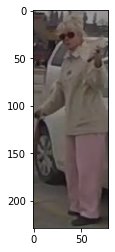

In [0]:
im=Image.open('00351.png')
im=im.crop([550.0, 691.0, 629.0, 920.0])
plt.imshow(im) 
im.size

In [0]:
 jaad['video_0001']['ped_annotations']['0_1_3b'].keys()

dict_keys(['old_id', 'frames', 'bbox', 'occlusion', 'behavior', 'attributes', 'appearance'])

In [0]:
from google.colab.patches import cv2_imshow

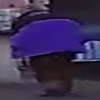

In [0]:
cv2_imshow(train_jaad_images_X[1][:,:,1,:])

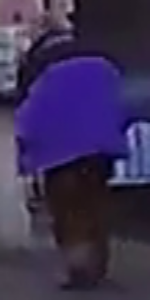

In [0]:
a = train_jaad_images_X[1][:,:,1,:] 
cv2_imshow(cv2.resize(a,(150,300)))

In [0]:
test_videos_X_data.shape

(24,)

In [0]:
train_videos_X_data.shape

(465,)

In [0]:
465+24

489